# Classification des Revenus avec XGBoost sur le Jeu de Données Adult
Ce notebook présente un projet de science des données responsable visant à prédire si une personne gagne plus de 50 000 $ (`>50K`) par an en utilisant le jeu de données **Adult**. Nous utiliserons **XGBoost**, un algorithme d'apprentissage supervisé basé sur les arbres de décision, pour effectuer cette classification.

In [14]:

!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 882.6 kB/s eta 0:02:21
   ---------------------------------------- 0.5/124.9 MB 882.6 kB/s eta 0:02:21
   ---------------------------------------- 0.5/124.9 MB 88


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
import shap

%matplotlib inline

c:\Users\georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
# Charger les données depuis un fichier CSV
data = pd.read_csv('adult.data', header=None, names=column_names,na_values=" ?")
print(data.head(40))

    age          workclass  fnlwgt      education  education_num  \
0    39          State-gov   77516      Bachelors             13   
1    50   Self-emp-not-inc   83311      Bachelors             13   
2    38            Private  215646        HS-grad              9   
3    53            Private  234721           11th              7   
4    28            Private  338409      Bachelors             13   
5    37            Private  284582        Masters             14   
6    49            Private  160187            9th              5   
7    52   Self-emp-not-inc  209642        HS-grad              9   
8    31            Private   45781        Masters             14   
9    42            Private  159449      Bachelors             13   
10   37            Private  280464   Some-college             10   
11   30          State-gov  141297      Bachelors             13   
12   23            Private  122272      Bachelors             13   
13   32            Private  205019     Assoc-acd

In [12]:
data.info()
missing_percentage = data.isnull().mean() * 100

# Afficher les résultats
print("Pourcentage de valeurs manquantes par colonne :")
print(missing_percentage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Pourcentage de valeurs manquantes par colonne :
age               0.000000
workclass         

In [13]:
print(data.isnull().sum())
# Supprimer les lignes contenant des valeurs manquantes
data = data.dropna()

print(f"Nombre de lignes restantes : {len(data)}")
print(data.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64
Nombre de lignes restantes : 30162
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [14]:
# Imputer les valeurs manquantes
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer.fit_transform(data[categorical_features])

In [ ]:
# Binarisation de l'âge
median_age = data['age'].median()
print(median_age)
data['age_binary'] = data['age'].apply(lambda x: 'Young' if x <= median_age else 'Old')
data = data.drop('age', axis=1)

In [16]:
# Prétraitement des variables catégorielles et numériques
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [17]:
# Séparer les caractéristiques et la cible
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Afficher les proportions
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de validation : {len(X_val)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


Taille de l'ensemble d'entraînement : 21716
Taille de l'ensemble de validation : 5429
Taille de l'ensemble de test : 3017


In [ ]:
# Pipeline avec XGBoost
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
clf_pipeline.fit(X_train, y_train)

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2266
           1       0.77      0.68      0.72       751

    accuracy                           0.87      3017
   macro avg       0.83      0.80      0.82      3017
weighted avg       0.86      0.87      0.87      3017

Exactitude : 0.8684
F1 Score : 0.7186


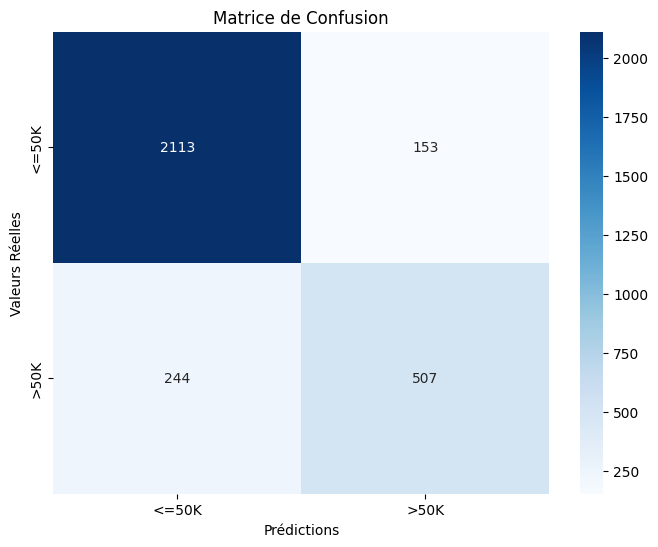

In [20]:


# Prédire les résultats sur l'ensemble de test
y_pred = clf_pipeline.predict(X_test)

# Imprimer le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une heatmap pour visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


# Part 2 : Fairness of the classifier

### Importation of needed libraires

In [1]:
import numpy as np
np.random.seed(42)

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import AdultDataset , BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from IPython.display import Markdown, display

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Step 2 Load dataset, specifying protected attribute, and split dataset into train and test

In [ ]:
#import pandas as pd
#from aif360.datasets import BinaryLabelDataset

# Load the dataset produced from part 1
#train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
#train_data = train_data.dropna()
# Est ce que c'est une alternative de faire 
# data = pd.read_csv('path_to_your_processed_data.csv')

# This filters the columns of the train_data to include only those columns that have numeric data types.
#train_data = train_data.select_dtypes(include=['number'])

# Specify protected attributes
#protected_attributes = ['age_binary', 'sex']

# Split the dataset into train and test sets
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['income'])

# Create BinaryLabelDataset for train and test sets
#train_dataset = BinaryLabelDataset(
#    df=train_data,
#    label_names=['income'],
#    protected_attribute_names=protected_attributes
#)

#test_dataset = BinaryLabelDataset(
#    df=test_data,
#    label_names=['income'],
#    protected_attribute_names=protected_attributes
#)


In [2]:
# We want to difine a custom preprocesing function (custom_preprocessing(df)) from the standat dataset class 
# that will be used to transform the dataset
def custom_preprocessing(df):
    median_age = df['age'].median()
    df['age_binary'] = df['age'].apply(lambda x: 1 if x <= median_age else 0)
    df = df.drop('age', axis=1)
    return df
# So what we did is to add a new column 'age_binary' to the dataset and drop the 'age' column, in order to 
# binarise the age column.

# Load the dataset with the library aif360
dataset_orig = AdultDataset(custom_preprocessing=custom_preprocessing,
                          protected_attribute_names=['age_binary', 'sex','race'], # race will remain because in the original library is defined with this protecte attribute
                          privileged_classes=[[1], ['Male'],['White']]) # We supposed that the privileged class is the old white male. It's also defined like this in the original library


Step 3 Compute fairness metric on original training dataset
The fairness metric is Statistical Parity Difference whitch measures the disparity in positive outcomes between unprivileged and privileged groups. It compares the probability of receiving a positive outcome for members of the unprivileged group against that for members of the privileged group.

In [3]:
# Define the privileged and unprivileged groups in order to compute the disparate impact
privileged_groups = [{'age_binary': 1, 'sex': 1}]  # Old males
unprivileged_groups = [{'age_binary': 0, 'sex': 0}]  # Young females

In [4]:
# Compute the fairness metric statistical parity measure, which is the difference in the mean prediction between the unprivileged and privileged groups.
# A negative value indicates less favorable outcomes for the unprivileged groups. in order to see if the dataset is biased
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.015898


As it can be seen from the privious cell, we conclude that there is a bias in this dataset because the statistical paity metric is not equal to zero. More specifficaly, in the unprivileged group we have 2% of peopele are suffering of unfairness.  

 Step 4 Mitigate bias by transforming the original dataset via technique to ensure the classifier is fair. Here we want to use the Pre-Processing method Reweighting for fairness. This method will simply assigns weights to samples to balance the representation of protected groups in the training process.

In [5]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig)

In [6]:
print('The 50 first instance weights originally:')
dataset_orig.instance_weights[:50]

The 50 first instance weights originally:


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
print('The 50 first instance weights after reweighing:')
dataset_transf_train.instance_weights[:50]

The 50 first instance weights after reweighing:


array([0.91752147, 1.        , 1.37514924, 1.        , 0.91752147,
       1.        , 1.        , 1.        , 1.        , 0.91752147,
       1.        , 1.        , 1.        , 0.91752147, 0.90006666,
       1.        , 1.37514924, 1.        , 0.91752147, 0.91752147,
       1.        , 0.91752147, 0.91752147, 1.        , 0.91752147,
       1.        , 0.90006666, 0.91752147, 0.91752147, 1.        ,
       1.37514924, 0.91752147, 0.91752147, 0.91752147, 1.        ,
       1.        , 0.91752147, 0.91752147, 0.91752147, 1.        ,
       1.        , 1.        , 0.90006666, 0.90006666, 0.91752147,
       1.        , 1.        , 1.37514924, 1.        , 1.        ])

We can clearly see from the cell above that the reweight method of transforming the dataset into a fair one worked.


Step 5 Compute fairness metric on transformed dataset


In [8]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


Step 6: Comparision between the classifier and the fair classifier

In [ ]:
# We need to extract the target attribut in another viriable (y) in order to train the model
X = dataset_orig.features 
y = dataset_orig.labels.ravel() 

print(X.shape)
print(y.shape)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset_orig, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)



(45222, 98)
(45222,)


TypeError: Singleton array array(               instance weights      features                           \
                                              protected attribute        
                                education-num                race  sex   
instance names                                                           
0                           1.0           7.0                 0.0  1.0   
1                           1.0           9.0                 1.0  1.0   
2                           1.0          12.0                 1.0  1.0   
3                           1.0          10.0                 0.0  1.0   
5                           1.0           6.0                 1.0  1.0   
...                         ...           ...                 ...  ...   
48837                       1.0          12.0                 1.0  0.0   
48838                       1.0           9.0                 1.0  1.0   
48839                       1.0           9.0                 1.0  0.0   
48840                       1.0           9.0                 1.0  1.0   
48841                       1.0           9.0                 1.0  0.0   

                                                                             \
                                                        protected attribute   
               capital-gain capital-loss hours-per-week          age_binary   
instance names                                                                
0                       0.0          0.0           40.0                 1.0   
1                       0.0          0.0           50.0                 0.0   
2                       0.0          0.0           40.0                 1.0   
3                    7688.0          0.0           40.0                 0.0   
5                       0.0          0.0           30.0                 1.0   
...                     ...          ...            ...                 ...   
48837                   0.0          0.0           38.0                 1.0   
48838                   0.0          0.0           40.0                 0.0   
48839                   0.0          0.0           40.0                 0.0   
48840                   0.0          0.0           20.0                 1.0   
48841               15024.0          0.0           40.0                 0.0   

                                                          ...  \
                                                          ...   
               workclass=Federal-gov workclass=Local-gov  ...   
instance names                                            ...   
0                                0.0                 0.0  ...   
1                                0.0                 0.0  ...   
2                                0.0                 1.0  ...   
3                                0.0                 0.0  ...   
5                                0.0                 0.0  ...   
...                              ...                 ...  ...   
48837                            0.0                 0.0  ...   
48838                            0.0                 0.0  ...   
48839                            0.0                 0.0  ...   
48840                            0.0                 0.0  ...   
48841                            0.0                 0.0  ...   

                                                                   \
                                                                    
               native-country=Puerto-Rico native-country=Scotland   
instance names                                                      
0                                     0.0                     0.0   
1                                     0.0                     0.0   
2                                     0.0                     0.0   
3                                     0.0                     0.0   
5                                     0.0                     0.0   
...                                   ...                     ...   
48837                                 0.0                     0.0   
48838                                 0.0                     0.0   
48839                                 0.0                     0.0   
48840                                 0.0                     0.0   
48841                                 0.0                     0.0   

                                                           \
                                                            
               native-country=South native-country=Taiwan   
instance names                                              
0                               0.0                   0.0   
1                               0.0                   0.0   
2                               0.0                   0.0   
3                               0.0                   0.0   
5                               0.0                   0.0   
...                             ...                   ...   
48837                           0.0                   0.0   
48838                           0.0                   0.0   
48839                           0.0                   0.0   
48840                           0.0                   0.0   
48841                           0.0                   0.0   

                                                                       \
                                                                        
               native-country=Thailand native-country=Trinadad&Tobago   
instance names                                                          
0                                  0.0                            0.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                                  0.0                            0.0   
5                                  0.0                            0.0   
...                                ...                            ...   
48837                              0.0                            0.0   
48838                              0.0                            0.0   
48839                              0.0                            0.0   
48840                              0.0                            0.0   
48841                              0.0                            0.0   

                                                                    \
                                                                     
               native-country=United-States native-country=Vietnam   
instance names                                                       
0                                       1.0                    0.0   
1                                       1.0                    0.0   
2                                       1.0                    0.0   
3                                       1.0                    0.0   
5                                       1.0                    0.0   
...                                     ...                    ...   
48837                                   1.0                    0.0   
48838                                   1.0                    0.0   
48839                                   1.0                    0.0   
48840                                   1.0                    0.0   
48841                                   1.0                    0.0   

                                         labels  
                                                 
               native-country=Yugoslavia         
instance names                                   
0                                    0.0    0.0  
1                                    0.0    0.0  
2                                    0.0    1.0  
3                                    0.0    1.0  
5                                    0.0    0.0  
...                                  ...    ...  
48837                                0.0    0.0  
48838                                0.0    1.0  
48839                                0.0    0.0  
48840                                0.0    0.0  
48841                                0.0    1.0  

[45222 rows x 100 columns], dtype=object) cannot be considered a valid collection.